# MCNB modelling

Multi-Class Naive Bayes modelling.

In [1]:
from itertools import chain, combinations

from collections import OrderedDict as odict

from math import ceil

from rdkit import SimDivFilters, DataStructs

from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.externals import joblib

import warnings

import seaborn as sns

from local_utils.rdkit_utils import FP

## Config

In [24]:
# Fraction of data to take as test set...

test_fraction = 1/4

# Number of times to repeat model-building/prediction process...

n_repeats = 10

In [3]:
# Ignore 'deprecation' warnings...

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [4]:
sns.set()

cfi = chain.from_iterable

In [5]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

## Reload  data

In [6]:
# Active compounds ...

all_actives, all_mols = pd.read_pickle('actives.pkl')

all_actives.shape[0], all_actives['symbol'].unique().size, all_actives['usmiles'].unique().size, all_mols.shape[0]

(167055, 138, 104749, 104749)

In [7]:
all_actives.head(1)

,symbol,usmiles
symbol,,
ABCB1,ABCB1,C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12


,mol,FP,core_smiles
usmiles,,,
C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12,,"[0 0 0 ..., 0 0 0]",O=c1cc(-c2ccccc2)oc2ccccc12

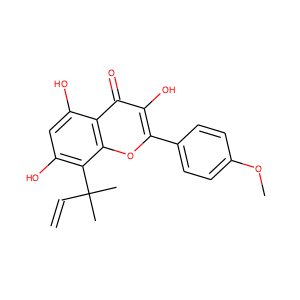

In [8]:
all_mols.head(1)

## Random picking

In [9]:
def reformat_and_add_mols(df):
    
    """Reformat to list of symbols at which each compound is active"""
    
    return df.groupby('usmiles').apply(lambda x: x['symbol'].tolist()).to_frame('symbols')\
             .merge(all_mols[['FP']], left_index=True, right_index=True)\
             .reset_index(drop=False)

In [10]:
symbols = all_actives.index.unique().tolist()

len(symbols)

138

In [11]:
compounds = set(all_actives['usmiles'])

len(compounds)

104749

In [25]:
# 1 = actives test set, 2 = inactives test set

all_results_1, all_results_2 = [], []

for n in range(1, n_repeats+1):
    
    logging.info("Starting run {}/{}...".format(n, n_repeats))
    
    ######
    
    train, test_1, test_2 = [], [], []

    for symbol in symbols:
        
        # Split active compounds for symbol into test and training sets...

        actives = all_actives.loc[symbol]['usmiles'].values

        n_test = int(ceil(actives.size * test_fraction))
        
        idx = np.random.permutation(actives.size)
        
        train.append(pd.DataFrame( {'symbol': symbol, 'usmiles': actives[idx[n_test:]]}))
        
        test_1.append(pd.DataFrame({'symbol': symbol, 'usmiles': actives[idx[:n_test]]}))
        
        # Inactives...
        
        inactives = np.array(list(compounds.difference(set(actives)))) # Compounds not active for the this target
        
        idx = np.random.permutation(inactives.size)
        
        test_2.append(pd.DataFrame({'symbol': symbol, 'usmiles': inactives[idx[:n_test]]})) # Inactives test set is same size as actives test set

    train, test_1, test_2 = [reformat_and_add_mols(pd.concat(x)) for x in [train, test_1, test_2]]
    
    logging.info("  done data split")
    
    ######

    # Fit model using training set...

    X = [x.fp for x in train['FP']]

    y = train['symbols'].tolist()

    classifier = OneVsRestClassifier(MultinomialNB())

    classifier.fit(X, y)
    
    logging.info("  fit model")

    ######

    # Predict actives test set...

    X = [x.fp for x in test_1['FP']]

    predictions_1 = classifier.predict(X)
    
    # For each compound-symbol pair in the actives test set, is that activity (rightly) predicted by the model?

    predictions_1 = {x: set(y) for x, y in zip(test_1['usmiles'], predictions_1)} # Reformat predictions for straightforward lookup

    results_1 = pd.DataFrame(list(cfi(((usmiles, symbol, symbol in predictions_1[usmiles]) for symbol in symbols) for usmiles, symbols in test_1[['usmiles', 'symbols']].itertuples(index=False))), columns=['usmiles', 'symbol', 'predicted'])
    
    all_results_1.append(results_1)
    
    logging.info("  predicted actives")
    
    #######
    
    # Predict inactives test set...
    
    X = [x.fp for x in test_2['FP']]

    predictions_2 = classifier.predict(X)
    
    # For each compound-symbol pair in the inactives test set, is that activity (wrongly) predicted by the model?
    
    predictions_2 = {x: set(y) for x, y in zip(test_2['usmiles'], predictions_2)} # Reformat predictions for straightforward look

    results_2 = pd.DataFrame(list(cfi(((usmiles, symbol, symbol in predictions_2[usmiles]) for symbol in symbols) for usmiles, symbols in test_2[['usmiles', 'symbols']].itertuples(index=False))), columns=['usmiles', 'symbol', 'predicted'])
    
    all_results_2.append(results_2)
    
    logging.info("  predicted inactives")
        
logging.info("Finished.")

[2015/Aug/14 13:46:07 INFO    ] Starting run 1/10...
[2015/Aug/14 13:46:27 INFO    ]   done data split
[2015/Aug/14 13:48:59 INFO    ]   fit model
[2015/Aug/14 13:50:07 INFO    ]   predicted actives
[2015/Aug/14 13:51:12 INFO    ]   predicted inactives
[2015/Aug/14 13:51:12 INFO    ] Starting run 2/10...
[2015/Aug/14 13:51:33 INFO    ]   done data split
[2015/Aug/14 13:54:16 INFO    ]   fit model
[2015/Aug/14 13:55:27 INFO    ]   predicted actives
[2015/Aug/14 13:56:37 INFO    ]   predicted inactives
[2015/Aug/14 13:56:37 INFO    ] Starting run 3/10...
[2015/Aug/14 13:56:56 INFO    ]   done data split
[2015/Aug/14 13:59:33 INFO    ]   fit model
[2015/Aug/14 14:00:43 INFO    ]   predicted actives
[2015/Aug/14 14:01:53 INFO    ]   predicted inactives
[2015/Aug/14 14:01:53 INFO    ] Starting run 4/10...
[2015/Aug/14 14:02:12 INFO    ]   done data split
[2015/Aug/14 14:04:45 INFO    ]   fit model
[2015/Aug/14 14:05:51 INFO    ]   predicted actives
[2015/Aug/14 14:06:59 INFO    ]   predicte

In [26]:
pickle.dump([all_results_1, all_results_2], open('all_results.pkl', 'w'))